## Импорты

In [ ]:
from IPython.display import clear_output

In [ ]:
cd /content/drive/MyDrive/MMP/Projects/Span_Detector

/content/drive/MyDrive/MMP/Projects/Span_Detector


In [ ]:
!pip3 install transformers pytorch_pretrained_bert
clear_output()

In [ ]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.nn.functional import relu, tanh, sigmoid
from data_load import num_task, masking, hier, sig, rel, tokenizer, VOCAB
import hp

import pathlib
from pathlib import Path
import numpy as np

clear_output()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%config InlineBackend.figure_formats = ['svg']

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = xm.xla_device()
device

'cuda'

## Фукнции для тренировки и валидации

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import os
import numpy as np
from data_load import PropDataset, pad, VOCAB, tokenizer, tag2idx, idx2tag, num_task, masking
import time
import warnings

#### train

In [ ]:
def train(model, iterator, optimizer, criterion, binary_criterion):
    model.train()

    train_losses = []

    for k, batch in enumerate(iterator):
        words, x, is_heads, att_mask, tags, y, seqlens = batch
        att_mask = torch.Tensor(att_mask)

        optimizer.zero_grad()
        x = x.to(torch.int64).to(device)
        att_mask = att_mask.to(torch.int64).to(device)
        logits, _ = model(x, attention_mask=att_mask)

        loss = []
        for i in range(num_task):
            logits[i] = logits[i].view(-1, logits[i].shape[-1]) # (N*T, 2)
            y[i] = y[i].view(-1).to(device)
            loss.append(criterion(logits[i], y[i]))

        if num_task == 1:
            joint_loss = loss[0]
        # elif num_task == 2:
        #     joint_loss = hp.alpha*loss[0] + (1-hp.alpha)*loss[1]

        joint_loss.backward()
        optimizer.step()
        train_losses.append(joint_loss.item())

        if k % 100 == 0: # monitoring
            print("step: {}, loss0: {}".format(k,loss[0].item()))

    train_loss = np.average(train_losses)

    return train_loss

#### eval

In [ ]:
def eval(model, iterator, f, criterion, binary_criterion):
    model.eval()

    valid_losses = []

    Words, Is_heads = [], []
    Tags = [[] for _ in range(num_task)]
    Y = [[] for _ in range(num_task)]
    Y_hats = [[] for _ in range(num_task)]
    with torch.no_grad():
        for _ , batch in enumerate(iterator):
            words, x, is_heads, att_mask, tags, y, seqlens = batch
            att_mask = torch.Tensor(att_mask)
            x = x.to(torch.int64).to(device)
            att_mask = att_mask.to(torch.int64).to(device)
            logits, y_hats = model(x, attention_mask=att_mask) # logits: (N, T, VOCAB), y: (N, T)
      
            loss = []
            for i in range(num_task):
                logits[i] = logits[i].view(-1, logits[i].shape[-1]) # (N*T, 2)
                y[i] = y[i].view(-1).to(device)
                loss.append(criterion(logits[i], y[i]))

            joint_loss = loss[0]
            valid_losses.append(joint_loss.item())
            Words.extend(words)
            Is_heads.extend(is_heads)

            for i in range(num_task):
                Tags[i].extend(tags[i])
                Y[i].extend(y[i].cpu().numpy().tolist())
                Y_hats[i].extend(y_hats[i].cpu().numpy().tolist())
    valid_loss = np.average(valid_losses) 

    with open(f, 'w') as fout:
        y_hats, preds = [[] for _ in range(num_task)], [[] for _ in range(num_task)]
        for words, is_heads, tags[0], y_hats[0] in zip(Words, Is_heads, *Tags, *Y_hats):
            for i in range(num_task):
                y_hats[i] = [hat for head, hat in zip(is_heads, y_hats[i]) if head == 1]
                preds[i] = [idx2tag[i][hat] for hat in y_hats[i]]
            fout.write(words.split()[0])
            fout.write("\n")
            for w, t1, p_1 in zip(words.split()[2:-1], tags[0].split()[1:-1], preds[0][1:-1]):
                fout.write("{} {} {} \n".format(w, t1, p_1))
            fout.write("\n")

    ## calc metric 
    y_true = np.array([tag2idx[0][line.split()[1]] for line in open(f, 'r').read().splitlines() if len(line.split()) > 1])
    y_pred = np.array([tag2idx[0][line.split()[2]] for line in open(f, 'r').read().splitlines() if len(line.split()) > 1])

    num_predicted, num_correct, num_gold = 0, 0, 0
    num_predicted += len(y_pred[y_pred > 1])
    num_correct += (np.logical_and(y_true == y_pred, y_true > 1)).astype(int).sum()
    num_gold += len(y_true[y_true > 1])

    ## распределение по классам
    num_predicted_array, num_correct_array, num_gold_array = np.zeros(len(VOCAB[0])), np.zeros(len(VOCAB[0])), np.zeros(len(VOCAB[0]))
    for i in range(2, len(VOCAB[0])):
        num_predicted_array[i] = len(y_pred[y_pred == i])
        num_correct_array[i] = (np.logical_and(y_true == y_pred, y_true == i)).astype(int).sum()
        num_gold_array[i] = len(y_true[y_true == i])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        precision = num_correct_array / num_predicted_array
        recall = num_correct_array / num_gold_array
    precision = np.nan_to_num(x=precision, nan=1.0)
    recall = np.nan_to_num(x=recall, nan=1.0)
    
    return precision, recall, valid_loss

#### visualise

In [ ]:
def visualize(model, iterator, f):#, criterion, binary_criterion):
    model.eval()

    Words, Is_heads = [], []
    Tags = [[] for _ in range(num_task)]
    Y = [[] for _ in range(num_task)]
    Y_hats = [[] for _ in range(num_task)]
    with torch.no_grad():
        for _ , batch in enumerate(iterator):
            words, x, is_heads, att_mask, tags, y, seqlens = batch
            att_mask = torch.Tensor(att_mask)
            x = x.to(torch.int64).to(device)
            att_mask = att_mask.to(torch.int64).to(device)
            logits, y_hats = model(x, attention_mask=att_mask) # logits: (N, T, VOCAB), y: (N, T)
      
            if num_task == 2 or masking:
                for i in range(num_task):
                    logits[i] = logits[i].view(-1, logits[i].shape[-1]) # (N*T, 2)
                y[0] = y[0].view(-1).to(device)
                y[1] = y[1].float().to(device)
            else:
                for i in range(num_task):
                    logits[i] = logits[i].view(-1, logits[i].shape[-1]) # (N*T, 2)
                    y[i] = y[i].view(-1).to(device)
            Words.extend(words)
            Is_heads.extend(is_heads)

            for i in range(num_task):
                Tags[i].extend(tags[i])
                Y[i].extend(y[i].cpu().numpy().tolist())
                Y_hats[i].extend(y_hats[i].cpu().numpy().tolist())
    y_hats, preds = [[] for _ in range(num_task)], [[] for _ in range(num_task)]
    res = ''
    last_article = ''
    if num_task == 1:
        for words, is_heads, tags[0], y_hats[0] in zip(Words, Is_heads, *Tags, *Y_hats):
            for i in range(num_task):
                y_hats[i] = [hat for head, hat in zip(is_heads, y_hats[i]) if head == 1]
                preds[i] = [idx2tag[i][hat] for hat in y_hats[i]]
            if str(words.split()[0]) != last_article:
                res += '<br><center><h4>' + str(words.split()[0]) + '</h4></center><br>'
                last_article = str(words.split()[0])
            for w, t1, p_1 in zip(words.split()[2:-1], tags[0].split()[1:-1], preds[0][1:-1]):
                if t1 == p_1 and p_1 != 'O':
                    res += f' <span style="background-color:green; color:white", data-tooltip="{p_1}"><b>{w}</b></span> '
                elif t1 != 'O' and p_1 != 'O':
                    res += f' <span style="background-color:orange; color:white", data-tooltip="right:{t1} pred:{p_1}"><b>{w}</b></span> '
                elif t1 != 'O' or p_1 != 'O':
                    res += f' <span style="background-color:red; color:white", data-tooltip="right:{t1} pred:{p_1}"><b>{w}</b></span> '
                else:
                    res += str(w) + ' '
    # else:
    #     for words, is_heads, tags[0], tags[1], y_hats[0], y_hats[1] in zip(Words, Is_heads, *Tags, *Y_hats):
    #         if str(words.split()[0]) != last_article:
    #             res += '<br><center><h4>' + str(words.split()[0]) + '</h4></center><br>'
    #             last_article = str(words.split()[0])
    #         y_hats[0] = [hat for head, hat in zip(is_heads, y_hats[0]) if head == 1]
    #         preds[0] = [idx2tag[0][hat] for hat in y_hats[0]]
    #         preds[1] = idx2tag[1][y_hats[1]]
    #         for w, t1, p_1 in zip(words.split()[2:-1], tags[0].split()[1:-1], preds[0][1:-1]):
    #             if t1 == p_1 and p_1 != 'O':
    #                 res += f' <span style="background-color:green; color:white", data-tooltip="{p_1}"><b>{w}</b></span> '
    #             elif t1 != 'O' or p_1 != 'O':
    #                 res += f' <span style="background-color:red; color:white", data-tooltip="right:{t1} pred:{p_1}"><b>{w}</b></span> '
    #             else:
    #                 res += str(w) + ' '
    return res

## Модель

In [ ]:
from transformers import RobertaConfig, RobertaModel, BertConfig, BertModel, AutoModel
from transformers import PreTrainedModel, create_optimizer, Adafactor
from pytorch_pretrained_bert import BertAdam

#### Without pooling

In [ ]:
class SpanDetector(nn.Module):
    def __init__(self):
        super(SpanDetector, self).__init__()
        config = BertConfig()
        self.bert = BertModel.from_pretrained("bert-base-cased")
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.ModuleList([nn.Linear(config.hidden_size, len(VOCAB[i])) for i in range(num_task)])

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        sequence_output, pooled_output = self.bert(input_ids, token_type_ids, attention_mask, return_dict=False)
        sequence_output = self.dropout(sequence_output)
        logits = [self.classifier[i](sequence_output) for i in range(num_task)]
        y_hats = [logits[i].argmax(-1) for i in range(num_task)]

        return logits, y_hats

#### With pooling

In [ ]:
class SpanDetector1(nn.Module):
    def __init__(self):
        super(SpanDetector, self).__init__()
        config = BertConfig()
        self.bert = BertModel.from_pretrained("bert-base-cased")
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.ModuleList([nn.Linear(4 * config.hidden_size, len(VOCAB[i])) for i in range(num_task)])

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        out = self.bert(input_ids, token_type_ids, attention_mask, return_dict=False, 
                                                   output_hidden_states=True)
        pooled_output = torch.cat((out[2][-2], out[2][-3], out[2][-4], out[2][-5]), axis=2)
        # print(pooled_output.shape)
        sequence_output = self.dropout(pooled_output)
        logits = [self.classifier[i](sequence_output) for i in range(num_task)]
        y_hats = [logits[i].argmax(-1) for i in range(num_task)]

        return logits, y_hats

#### SpanBERT

In [ ]:
class SpanDetector2(nn.Module):
    def __init__(self):
        super(SpanDetector, self).__init__()
        # config = RobertaConfig()
        # self.bert = RobertaModel.from_pretrained("roberta-base")
        config = BertConfig()
        self.bert = AutoModel.from_pretrained("/content/drive/MyDrive/MMP/Projects/Span_Detector/pretrained/spanbert_hf_base/")
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.ModuleList([nn.Linear(config.hidden_size, len(VOCAB[i])) for i in range(num_task)])

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        # print(input_ids.shape, attention_mask.shape)
        # print(type(input_ids), type(token_type_ids), type(attention_mask))
        sequence_output, pooled_output = self.bert(input_ids, token_type_ids, attention_mask, return_dict=False)
        sequence_output = self.dropout(sequence_output)
        logits = [self.classifier[i](sequence_output) for i in range(num_task)]
        y_hats = [logits[i].argmax(-1) for i in range(num_task)]

        return logits, y_hats

## Тренировка модели

In [ ]:
import hp
hp.n_epochs = 10
BATCH_SIZE = hp.batch_size
LEARNING_RATE = hp.lr
N_EPOCHS = hp.n_epochs
PATIENCE = hp.patience

In [ ]:
model = SpanDetector()
model.to(device)
!nvidia-smi -L

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-56dbbfe4-4082-a3af-6303-a3328bbdba8f)


In [ ]:
train_dataset = PropDataset('./data/protechn_corpus_eval/train', False)
eval_dataset = PropDataset('./data/protechn_corpus_eval/dev', True)

In [ ]:
len(train_dataset), len(eval_dataset)

(14808, 2022)

In [ ]:
train_dataset = PropDataset('./data/protechn_corpus_eval/train', False)
eval_dataset = PropDataset('./data/protechn_corpus_eval/dev', True)
test_dataset = PropDataset('./data/protechn_corpus_eval/test', True)
visial_dataset = PropDataset('./data/protechn_corpus_eval/visual', True)

train_iter = data.DataLoader(dataset=train_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True,
                                num_workers=1,
                                collate_fn=pad)
eval_iter = data.DataLoader(dataset=eval_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                num_workers=1,
                                collate_fn=pad)
test_iter = data.DataLoader(dataset=test_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                num_workers=1,
                                collate_fn=pad)
visual_iter = data.DataLoader(dataset=visial_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                num_workers=1,
                                collate_fn=pad)

In [ ]:
timestr = time.strftime("%Y%m%d-%H%M%S") # needed to be fixed
warmup_proportion = 0.1
num_train_optimization_steps = int(len(train_dataset) / hp.batch_size ) * hp.n_epochs
param_optimizer = list(model.named_parameters())
param_optimizer = [n for n in param_optimizer if 'pooler' not in n[0]]
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = BertAdam(optimizer_grouped_parameters,
                        lr=hp.lr,
                        warmup=warmup_proportion,
                        t_total=num_train_optimization_steps)
criterion = nn.CrossEntropyLoss(ignore_index=0)
binary_criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([3932/14263]).to(device))

In [ ]:
f1_train = []
f1_eval = []
for epoch in range(1, N_EPOCHS+1):
    print(f"=========eval at epoch={epoch}=========")
    if not os.path.exists('checkpoints'): os.makedirs('checkpoints')
    if not os.path.exists('results'): os.makedirs('results')
    fname = os.path.join('checkpoints', timestr)
    spath = os.path.join('checkpoints', timestr+".pt")

    train_loss = train(model, train_iter, optimizer, criterion, binary_criterion)

    # precision, recall, f1_eval, valid_loss = eval(model, eval_iter, fname, criterion, binary_criterion)
    precision, recall, valid_loss = eval(model, eval_iter, fname, criterion, binary_criterion)
    f1_eval.append([precision, recall])
    precision, recall, valid_loss = eval(model, train_iter, fname, criterion, binary_criterion)
    f1_train.append([precision, recall])

    epoch_len = len(str(N_EPOCHS))
    print_msg = (f'[{epoch:>{epoch_len}}/{N_EPOCHS:>{epoch_len}}]     ' +
                    f'train_loss: {train_loss:.5f} ' +
                    f'valid_loss: {valid_loss:.5f}')
    print(print_msg)
    # f1_array.append((f1_eval, f1_train))
    # f1_array.append(f1_eval)
    # print('Class\t\tprecision\t\trecall')
    # for i in range(2, len(VOCAB[0])):
    #     print(f'{VOCAB[0][i]}\t{precision[i]:.4f}\t{recall[i]:.4f}')
    # if f1_eval > best_f1:
    #     best_f1 = f1_eval
    #     torch.save(model.state_dict(), spath)
    #     print("Best model saved")

=========eval at epoch=1=========
step: 0, loss0: 3.350395917892456
step: 100, loss0: 0.7875802516937256
step: 200, loss0: 1.0364298820495605
step: 300, loss0: 0.7552422285079956
step: 400, loss0: 0.8581026196479797
[ 1/10]     train_loss: 0.84383 valid_loss: 0.59767
=========eval at epoch=2=========
step: 0, loss0: 0.48206400871276855
step: 100, loss0: 0.5507694482803345
step: 200, loss0: 0.6373849511146545
step: 300, loss0: 0.6091655492782593
step: 400, loss0: 0.8262253999710083
[ 2/10]     train_loss: 0.56540 valid_loss: 0.34741
=========eval at epoch=3=========
step: 0, loss0: 0.3435242474079132
step: 100, loss0: 0.47602930665016174
step: 200, loss0: 0.20682235062122345
step: 300, loss0: 0.3479764461517334
step: 400, loss0: 0.4015803933143616
[ 3/10]     train_loss: 0.33355 valid_loss: 0.17880
=========eval at epoch=4=========
step: 0, loss0: 0.41158273816108704
step: 100, loss0: 0.16252271831035614
step: 200, loss0: 0.20751281082630157
step: 300, loss0: 0.15912841260433197
step: 4

Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.
Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.
Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.
Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.
Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.
Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.
Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.
Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_to

[10/10]     train_loss: 0.04874 valid_loss: 0.03522


In [ ]:
f1_train = np.array(f1_train)
f1_eval = np.array(f1_eval)

In [ ]:
np.save('f1_train.npy', f1_train)
np.save('f1_eval.npy', f1_eval)

In [ ]:
res = os.path.join('results', timestr)
# load the last checkpoint with the best model
model.load_state_dict(torch.load(spath))
precision, recall, f1, test_loss = eval(model, test_iter, res, criterion, binary_criterion)
print_msg = (f'test_precision: {precision:.5f} ' +
                f'test_recall: {recall:.5f} ' +
                f'test_f1: {f1:.5f}')
print(print_msg)

num_predicted:4074
num_correct:992
num_gold:8689
precision=0.2435
recall=0.1142
f1=0.1554
test_precision: 0.24350 test_recall: 0.11417 test_f1: 0.15545


In [ ]:
f1_train[:, 0, 2]

array([0.28081123, 0.1971831 , 0.29032258, 0.24864865, 0.27272727,
       0.25116279, 0.25061425, 0.27135678, 0.25945946, 0.26614987])

In [ ]:
for i, k in enumerate(VOCAB[0]):
    print(i, k)

0 [PAD]
1 O
2 Name_Calling,Labeling
3 Repetition
4 Slogans
5 Appeal_to_fear-prejudice
6 Doubt
7 Exaggeration,Minimisation
8 Flag-Waving
9 Loaded_Language
10 Reductio_ad_hitlerum
11 Bandwagon
12 Causal_Oversimplification
13 Obfuscation,Intentional_Vagueness,Confusion
14 Appeal_to_Authority
15 Black-and-White_Fallacy
16 Thought-terminating_Cliches
17 Red_Herring
18 Straw_Men
19 Whataboutism


In [ ]:
import matplotlib.gridspec as gridspec

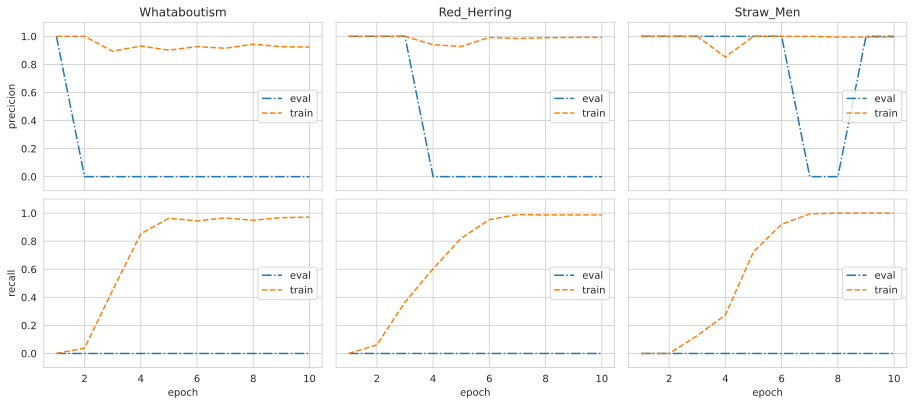

In [ ]:
rows, cols = 2, 3
fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(cols * 5, rows * 3))

num = 19
axs[0, 0].plot(range(1, 11), f1_eval[:, 0, num], '-.', label='eval')
axs[0, 0].plot(range(1, 11), f1_train[:, 0, num], '--', label='train')
axs[0, 0].legend(loc='center right')
axs[0, 0].set(xlabel='epoch', ylabel='precicion')
axs[0, 0].set_ylim([-0.1, 1.1])
axs[0, 0].set_title(VOCAB[0][num])

axs[1, 0].plot(range(1, 11), f1_eval[:, 1, num], '-.', label='eval')
axs[1, 0].plot(range(1, 11), f1_train[:, 1, num], '--', label='train')
axs[1, 0].legend(loc='center right')
axs[1, 0].set(xlabel='epoch', ylabel='recall')
axs[1, 0].set_ylim([-0.1, 1.1])

###

num = 17
axs[0, 1].plot(range(1, 11), f1_eval[:, 0, num], '-.', label='eval')
axs[0, 1].plot(range(1, 11), f1_train[:, 0, num], '--', label='train')
axs[0, 1].legend(loc='center right')
axs[0, 1].set(xlabel='epoch', ylabel='precicion')
axs[0, 1].set_ylim([-0.1, 1.1])
axs[0, 1].set_title(VOCAB[0][num])

axs[1, 1].plot(range(1, 11), f1_eval[:, 1, num], '-.', label='eval')
axs[1, 1].plot(range(1, 11), f1_train[:, 1, num], '--', label='train')
axs[1, 1].legend(loc='center right')
axs[1, 1].set(xlabel='epoch', ylabel='recall')
axs[1, 1].set_ylim([-0.1, 1.1])

###

num = 18
axs[0, 2].plot(range(1, 11), f1_eval[:, 0, num], '-.', label='eval')
axs[0, 2].plot(range(1, 11), f1_train[:, 0, num], '--', label='train')
axs[0, 2].legend(loc='center right')
axs[0, 2].set(xlabel='epoch', ylabel='precicion')
axs[0, 2].set_ylim([-0.1, 1.1])
axs[0, 2].set_title(VOCAB[0][num])

axs[1, 2].plot(range(1, 11), f1_eval[:, 1, num], '-.', label='eval')
axs[1, 2].plot(range(1, 11), f1_train[:, 1, num], '--', label='train')
axs[1, 2].legend(loc='center right')
axs[1, 2].set(xlabel='epoch', ylabel='recall')
axs[1, 2].set_ylim([-0.1, 1.1])

# for ax in axs.flat:
    # ax.set(xlabel='epoch', ylabel='precicion')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.05, 
                    hspace=0.05)
plt.savefig('minor_classes_pr.pdf')

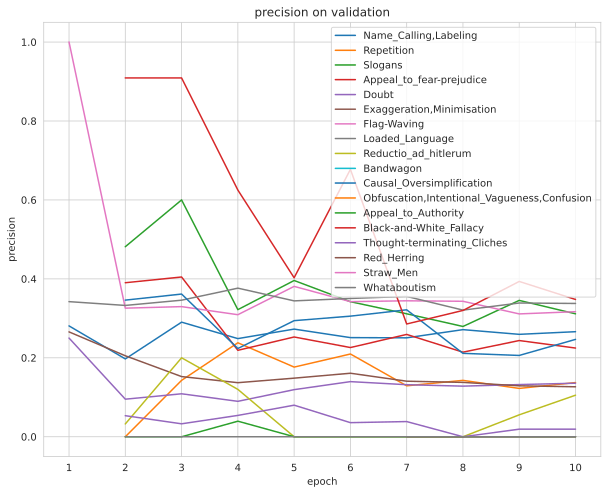

In [ ]:
plt.figure(figsize=(10, 8))
for i in range(2, len(VOCAB[0])):
    sns.lineplot(x=range(1, 11), y=f1_array[:, 0, i], label=VOCAB[0][i])
# sns.lineplot(x=range(1, 11), y=f1_lr1e5_array, color='blue', linestyle='dotted', label='lr=1e-5')
# sns.lineplot(x=range(1, 11), y=f1_lr1e4_array, color='green', linestyle='dashdot', label='lr=1e-4')
plt.title('precision on validation')
plt.xlabel('epoch')
plt.ylabel('precision')
plt.xticks(range(1, 11))
plt.show()

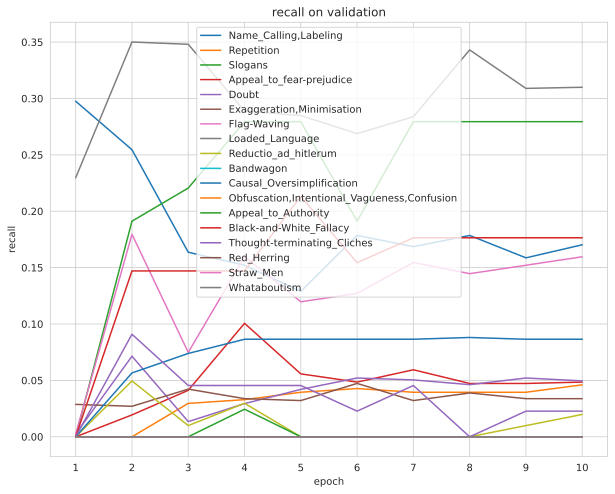

In [ ]:
plt.figure(figsize=(10, 8))
for i in range(2, len(VOCAB[0])):
    sns.lineplot(x=range(1, 11), y=f1_array[:, 1, i], label=VOCAB[0][i])
# sns.lineplot(x=range(1, 11), y=f1_lr1e5_array, color='blue', linestyle='dotted', label='lr=1e-5')
# sns.lineplot(x=range(1, 11), y=f1_lr1e4_array, color='green', linestyle='dashdot', label='lr=1e-4')
plt.title('recall on validation')
plt.xlabel('epoch')
plt.ylabel('recall')
plt.xticks(range(1, 11))
plt.show()

## Debug

In [ ]:
from transformers import DataCollatorWithPadding

In [ ]:
train_dataset = PropDataset('./data/protechn_corpus_eval/train', False)
eval_dataset = PropDataset('./data/protechn_corpus_eval/dev', True)
test_dataset = PropDataset('./data/protechn_corpus_eval/test', True)
visial_dataset = PropDataset('./data/protechn_corpus_eval/visual', True)

train_iter = data.DataLoader(dataset=train_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True,
                                num_workers=1,
                                collate_fn=pad)
eval_iter = data.DataLoader(dataset=eval_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                num_workers=1,
                                collate_fn=pad)
test_iter = data.DataLoader(dataset=test_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                num_workers=1,
                                collate_fn=pad)
visual_iter = data.DataLoader(dataset=visial_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                num_workers=1,
                                collate_fn=pad)

In [ ]:
words, x, is_heads, att_mask, tags, y, seqlens = train_dataset[0]

In [ ]:
x = torch.Tensor(x).to(torch.int64).reshape(1, -1)
att_mask = torch.Tensor([att_mask]).to(torch.int64)

In [ ]:
logits, _ = model(x, attention_mask=att_mask)

torch.Size([1, 107]) torch.Size([1, 93])
<class 'torch.Tensor'> <class 'NoneType'> <class 'torch.Tensor'>


RuntimeError: ignored

## Визуализация

In [ ]:
from IPython.core.display import HTML

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/MMP/Projects/Span_Detector/checkpoints/20220528-190628.pt'))

<All keys matched successfully>

In [ ]:
html_code = """
<!DOCTYPE html>
<html>
<head>
<style>
    body { 
    margin-right: 25%; /* Отступ справа */
    margin-left: 15%; /* Отступ слева */
   }
   [data-tooltip] {
    position: relative; /* Относительное позиционирование */ 
   }
   [data-tooltip]::after {
    content: attr(data-tooltip); /* Выводим текст */
    position: absolute; /* Абсолютное позиционирование */
    width: 300px; /* Ширина подсказки */
    left: 0; top: 0; /* Положение подсказки */
    background: #3989c9; /* Синий цвет фона */
    color: #fff; /* Цвет текста */
    padding: 0.5em; /* Поля вокруг текста */
    box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.3); /* Параметры тени */
    pointer-events: none; /* Подсказка */
    opacity: 0; /* Подсказка невидима */
    transition: 0.5s; /* Время появления подсказки */
    z-index: 4;
   } 
   [data-tooltip]:hover::after {
    opacity: 1; /* Показываем подсказку */
    top: 2em; /* Положение подсказки */
   }
  </style>
</head>
<body>

<center><h2>Визуализация работы</h2></center>
<!-- <span style="background-color:red; color:white", data-tooltip="Всплывающая подсказка">My first paragraph.</span> -->
"""

In [ ]:
HTML(html_code + visualize(model, visual_iter, None) + "<br><br><br></body></html>")